In [1]:
import zipfile
import os

In [2]:
zip_file_path = '/content/aclImdb_v1.zip'

In [3]:
# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/aclImdb')

In [4]:
os.listdir('/content/aclImdb')

['aclImdb_v1']

In [5]:
import os
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [6]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
# Function to load data
def load_data(directory):
    data = []
    for label in ['pos', 'neg']:
        label_dir = os.path.join(directory, label)
        for file_name in os.listdir(label_dir):
            if file_name.endswith('.txt'):
                with open(os.path.join(label_dir, file_name), 'r', encoding='utf-8') as file:
                    review = file.read()
                    data.append((review, 1 if label == 'pos' else 0))
    return data

In [8]:
# Paths to training and testing directories
train_dir = '/content/aclImdb/aclImdb_v1/aclImdb/train'
test_dir = '/content/aclImdb/aclImdb_v1/aclImdb/test'

In [9]:
# Load training and testing data
train_data = load_data(train_dir)
test_data = load_data(test_dir)

In [10]:
# Combine and create DataFrame
data = train_data + test_data
df = pd.DataFrame(data, columns=['review', 'label'])

In [11]:
# Preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [12]:
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [13]:
# Apply preprocessing
df['review'] = df['review'].apply(preprocess_text)

# Display the first few rows of the DataFrame
df.head()

,review,label
0,eytan fox move viewer heart modest story takin...,1
1,fond film vexes many reviewer rank peter jacks...,1
2,sure movie historically accurate great enterta...,1
3,plot real horrific atmosphere really depressiv...,1
4,maybe intense fear hospital medical stuff one ...,1


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [15]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.2, random_state=42)


In [16]:
# Extract features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Initialize models
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    #'Support Vector Machine': SVC(probability=True)
}

In [19]:
results = {}

In [20]:
from sklearn.metrics import roc_curve, auc

In [25]:
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_tfidf, y_train)

    # Predict on the test data
    y_pred = model.predict(X_test_tfidf)
# Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
# Calculate ROC curve and ROC AUC score
    y_prob = model.predict_proba(X_test_tfidf)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
     # Print the results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("="*30)

Model: Multinomial Naive Bayes
Accuracy: 0.8572
Precision: 0.8534
Recall: 0.8663
F1 Score: 0.8598
ROC AUC: 0.9330
Model: Logistic Regression
Accuracy: 0.8928
Precision: 0.8847
Recall: 0.9060
F1 Score: 0.8952
ROC AUC: 0.9592


Logistic Regression is the better model based on all performance metrics (accuracy, precision, recall, F1 score, and ROC AUC). It consistently outperforms Multinomial Naive Bayes in this comparison.

In [24]:
results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'ROC Curve': (fpr, tpr, roc_auc)
    }

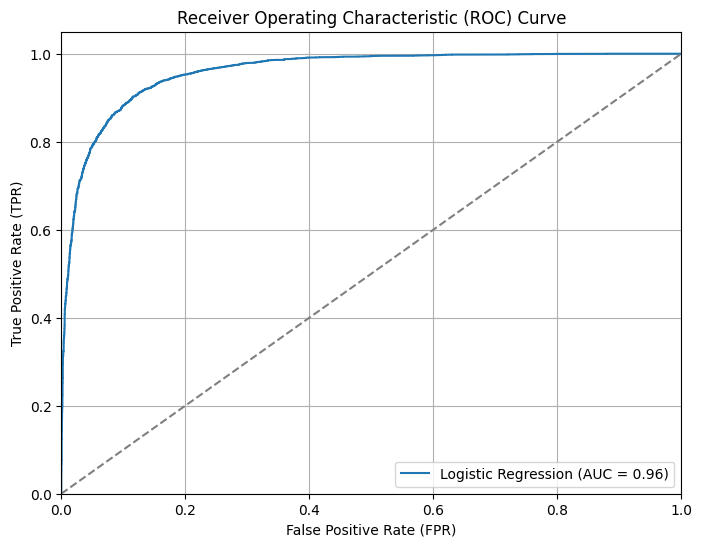

In [23]:

plt.figure(figsize=(8, 6))
for model_name, metrics in results.items():
    fpr, tpr, roc_auc = metrics['ROC Curve']
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Plot random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()